<a href="https://colab.research.google.com/github/danielazenkot/Big-Data-Project/blob/main/Preprocces_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use the API to collect data on the rain stations

In [ ]:
import json
import requests
url = "https://api.ims.gov.il/v1/envista/stations"
headers = {
'Authorization': 'ApiToken f058958a-d8bd-47cc-95d7-7ecf98610e47'
}
response = requests.request("GET", url, headers=headers)
data= json.loads(response.text.encode('utf8'))

# Extracting names and station IDs
import fnmatch
dict_stations = {
'BESOR FARM': [],
'LAHAV': [],
'SEDE BOQER': [],
'DOROT': [],
'BEER SHEVA': []
}


for station in data:
    name = station['name']
    station_id = station['stationId']
    if fnmatch.fnmatch(name, '*BEER SHEVA*'):
        dict_stations['BEER SHEVA'].append((station_id))
    if fnmatch.fnmatch(name, '*BESOR FARM*'):
        dict_stations['BESOR FARM'].append((station_id))
    if fnmatch.fnmatch(name, '*SEDE BOQER*'):
        dict_stations['SEDE BOQER'].append((station_id))
    if fnmatch.fnmatch(name, '*DOROT*'):
        dict_stations['DOROT'].append((station_id))
    if fnmatch.fnmatch(name, '*LAHAV*'):
        dict_stations['LAHAV'].append((station_id))

# Define your API call function
def make_api_call(value):
    url = f"https://api.ims.gov.il/v1/envista/stations/{value}"
    headers = {
    'Authorization': 'ApiToken f058958a-d8bd-47cc-95d7-7ecf98610e47'
    }
    try:
        response = requests.request("GET", url, headers=headers)
        response.raise_for_status()  # Raise exception for non-2xx status codes
        return True  # API call successful
    except Exception as e:
        print(f"API call failed for value {value}: {e}")
        return False  # API call failed

# Iterate over dictionary items
for key, values in dict_stations.items():
 # Iterate over values in the list
    i = 0
    while i < len(values):
        if not make_api_call(values[i]):
            # Remove the value if the API call fails
            del values[i]
        else:
            # Move to the next value if API call succeeds
            i += 1


print(dict_stations)


{'BESOR FARM': [58, 244], 'LAHAV': [350, 351], 'SEDE BOQER': [98, 251], 'DOROT': [79, 245], 'BEER SHEVA': [59, 60, 293, 411, 412]}


In [ ]:
import json
import requests
import pandas as pd
url = "https://api.ims.gov.il/v1/envista/stations"
headers = {
'Authorization': 'ApiToken f058958a-d8bd-47cc-95d7-7ecf98610e47'
}
response = requests.request("GET", url, headers=headers)
data= json.loads(response.text.encode('utf8'))
df = pd.DataFrame(data)
df[df['stationId'] == 79]['location']

43    {'latitude': 31.5036, 'longitude': 34.648}
Name: location, dtype: object

In [ ]:
import json
import requests
url = "https://api.ims.gov.il/v1/envista/stations"
headers = {
'Authorization': 'ApiToken f058958a-d8bd-47cc-95d7-7ecf98610e47'
}
response = requests.request("GET", url, headers=headers)
data= json.loads(response.text.encode('utf8'))

In [ ]:
dict_stations_LAHAV = {}
dict_stations_LAHAV['LAHAV'] = dict_stations['LAHAV']
dict_stations_LAHAV

{'LAHAV': [350, 351]}

In [ ]:
dict_stations_DOROT = {}
dict_stations_DOROT['DOROT'] = dict_stations['DOROT']
dict_stations_DOROT

{'DOROT': [79, 245]}

In [ ]:
dict_stations_BESOR= {}
dict_stations_BESOR['BESOR FARM'] = dict_stations['BESOR FARM']
dict_stations_BESOR

{'BESOR FARM': [58, 244]}

There were a lot of stations that are somewhat of dummy - no data was given be calling the station - examples were givn above.
After a check, it appears that only one station per city is callable, Hence the code below does is not inside the loop - checks for one connection per city, and them extract all the data we can. Note, Dr Merav and Prof Avshalom aggreed that the API is not very good.. Downloaded manually instead

In [ ]:
from datetime import datetime, timedelta
import pandas as pd
import json
import requests
import numpy as np

parameters_to_seek = ['TD', 'TDmax', 'TDmin', 'TG', 'Rain', 'RH', 'Ws10mm', 'WS1mm', 'WS', 'STDwd', 'WD']

# Define channel IDs and names beforehand
'''
channel_info = {
    1: 'rain_amount',
    5: 'WD',
    6: 'STDwd',
    7: 'TD',
    8: 'RH',
    9: 'TDmax',
    10: 'TDmin',
    11: 'WS1mm',
    12: 'Ws10mm',
}

'''
channel_info = {}

# just for an attempt try rahab

start_date = [i for i in range(2015, 2022)]
for k, v in dict_stations_DOROT.items():
    for year in start_date:
        flag = False
        for i in v:
            try:
                url = f"https://api.ims.gov.il/v1/envista/stations/{i}"
                headers = {
                    'Authorization': 'ApiToken f058958a-d8bd-47cc-95d7-7ecf98610e47'
                }
                response = requests.request("GET", url, headers=headers)
                channels_id = json.loads(response.text.encode('utf8'))

                for channel in channels_id['monitors']:
                    if channel['name'] in parameters_to_seek:
                        channel_info[channel['channelId']] = channel['name']

                # Pause execution for 1 second before making the next API call
                time.sleep(5)

                url = f"https://api.ims.gov.il/v1/envista/stations/{i}/data/?from={year}/09/01&to={year}/10/01"
                headers = {
                    'Authorization': 'ApiToken f058958a-d8bd-47cc-95d7-7ecf98610e47'
                }
                response = requests.get(url, headers=headers, verify=False)
                data = json.loads(response.text.encode('utf8'))
                flag = True
                break
            except Exception as e:
                print(f"fuck {year}")
                continue
            if flag == False:
                continue
        data_list = []
        for entry in data['data']:
            datetime_str = entry['datetime']
            original_datetime = datetime.fromisoformat(datetime_str[:-6])  # Parse without timezone offset
            timezone_offset = timedelta(hours=int(datetime_str[-5:-3]), minutes=int(datetime_str[-2:]))

            # Check if the timezone offset is not +03:00 (adjust as needed) - summer time!!!!
            if timezone_offset != timedelta(hours=3):
                # Adjust the datetime by adding the timezone offset - summer time!!!
                adjusted_datetime = original_datetime + (timedelta(hours=3) - timezone_offset)
            else:
                adjusted_datetime = original_datetime

            # Format the adjusted datetime as per your requirement
            formatted_datetime = adjusted_datetime.strftime('%d/%m/%Y %H:%M')
            # Define data dictionary to append
            data_dict = {'rain_station': k, 'start_rain': formatted_datetime}

            # Check if entry['channels'] exists and is not empty
            if 'channels' in entry and entry['channels']:
                # Collect existing channel IDs into a set
                existing_channel_ids = {channel['id'] for channel in entry['channels'] if 'id' in channel}

                # Iterate over predefined channel IDs and names
                for channel_id, channel_name in channel_info.items():
                    if channel_id in existing_channel_ids:
                        # Get the value if the channel exists
                        channel_value = next((channel['value'] for channel in entry['channels'] if channel.get('id') == channel_id and channel.get('status') == 1), np.nan)
                        data_dict[channel_name] = channel_value
                    else:
                        # Set NaN if the channel doesn't exist
                        data_dict[channel_name] = np.nan


            data_list.append(data_dict)
            #print(len(data_list))
        df = pd.DataFrame(data_list)
        #print(data_list[0:5])
        specific_path = "C:\\Users\\User\\Desktop\\BigDataProjectData\\"
        df.to_csv(f"{specific_path}{k}_station_10min_rain_0109{year}_0106{year+1}.csv", index=False)
        print(df.head())
        df.drop(df.index, inplace=True)

fuck 2015
fuck 2015
  rain_station        start_rain  Rain   WS    TD  TDmax  TDmin  WS1mm  \
0        DOROT  01/09/2020 00:00   0.0  1.8  25.1   25.1   25.0    2.3   
1        DOROT  01/09/2020 00:10   0.0  2.0  25.1   25.1   25.0    2.4   
2        DOROT  01/09/2020 00:20   0.0  2.2  25.1   25.2   25.0    2.7   
3        DOROT  01/09/2020 00:30   0.0  2.3  25.1   25.2   25.1    2.6   
4        DOROT  01/09/2020 00:40   0.0  2.3  25.1   25.1   25.1    2.7   

   Ws10mm    RH    TG  
0     2.0  89.0  24.6  
1     2.0  89.0  24.6  
2     2.3  89.0  24.8  
3     2.3  89.0  24.8  
4     2.4  89.0  24.7  
fuck 2016
fuck 2016
  rain_station        start_rain  Rain   WS    TD  TDmax  TDmin  WS1mm  \
0        DOROT  01/09/2020 00:00   0.0  1.8  25.1   25.1   25.0    2.3   
1        DOROT  01/09/2020 00:10   0.0  2.0  25.1   25.1   25.0    2.4   
2        DOROT  01/09/2020 00:20   0.0  2.2  25.1   25.2   25.0    2.7   
3        DOROT  01/09/2020 00:30   0.0  2.3  25.1   25.2   25.1    2.6   
4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_2000_2010_23160 = get_hidro_data('https://data.gov.il/api/3/action/datastore_search' ,'37f0e85c-c5ac-48a7-80e1-cb9c129a2e0b', 23160)
df_2011_2019_23160 = get_hidro_data('https://data.gov.il/api/3/action/datastore_search', '0c63d2ce-636c-4814-8a73-98820b9f0450', 23160)
df_2020_2023_23160 = get_hidro_data('https://data.gov.il/api/3/action/datastore_search', 'ff37292d-5b6d-4823-addf-1a1dd9ddf0b2', 23160)

df_2000_2010_23150 = get_hidro_data('https://data.gov.il/api/3/action/datastore_search' ,'37f0e85c-c5ac-48a7-80e1-cb9c129a2e0b', 23150)
df_2011_2019_23150 = get_hidro_data('https://data.gov.il/api/3/action/datastore_search', '0c63d2ce-636c-4814-8a73-98820b9f0450', 23150)
df_2020_2023_23150 = get_hidro_data('https://data.gov.il/api/3/action/datastore_search', 'ff37292d-5b6d-4823-addf-1a1dd9ddf0b2', 23150)

df_2000_2010_23105 = get_hidro_data('https://data.gov.il/api/3/action/datastore_search' ,'37f0e85c-c5ac-48a7-80e1-cb9c129a2e0b', 23105)
df_2011_2019_23105 = get_hidro_data('https://data.gov.il/api/3/action/datastore_search', '0c63d2ce-636c-4814-8a73-98820b9f0450', 23105)
df_2020_2023_23105 = get_hidro_data('https://data.gov.il/api/3/action/datastore_search', 'ff37292d-5b6d-4823-addf-1a1dd9ddf0b2', 23105)

df_hidro = pd.concat([df_2000_2010_23160, df_2011_2019_23160, df_2020_2023_23160,
                     df_2000_2010_23150, df_2011_2019_23150, df_2020_2023_23150,
                     df_2000_2010_23105,df_2011_2019_23105, df_2020_2023_23105] )
df_hidro = df_hidro[df_hidro['סוג זרימה'] == 'גאות'] # Filter only floods
print(df_hidro.shape)

(6735, 11)


In [ ]:
print(df_hidro.dtypes) #  change to datetime

_id                     int64
זיהוי תחנה              int64
שם תחנה                object
שם תחנה באנגלית        object
זמן מדידת ספיקה        object
רום המים (מ')          object
ספיקה (מ''ק/שנייה)    float64
סוג נתון               object
סוג זרימה              object
סוג רשומה              object
rank                  float64
dtype: object


In [ ]:
df_hidro['datetime'] = pd.to_datetime(df_hidro['זמן מדידת ספיקה'], format='%d/%m/%Y %H:%M:%S')
df_hidro['date']  = df_hidro['datetime'].dt.date
df_hidro['month'] = df_hidro['datetime'].dt.month
df_hidro = df_hidro[df_hidro['סוג זרימה'] == 'גאות']
df_hidro.sort_values(by = 'date', ascending = True, inplace = True)
df_hidro.iloc[1500:1550]

,_id,זיהוי תחנה,שם תחנה,שם תחנה באנגלית,זמן מדידת ספיקה,רום המים (מ'),ספיקה (מ''ק/שנייה),סוג נתון,סוג זרימה,סוג רשומה,rank,datetime,date,month
964,446695,23160,גרר - רעים,GERAR - RE'IM,29/10/2008 14:57:29,10.26,2.600,מדודים,גאות,נקודה פנימית,0.057309,2008-10-29 14:57:29,2008-10-29,10
258,446701,23160,גרר - רעים,GERAR - RE'IM,29/10/2008 17:53:24,10.13,0.906,מדודים,גאות,נקודה פנימית,0.057309,2008-10-29 17:53:24,2008-10-29,10
1271,446704,23160,גרר - רעים,GERAR - RE'IM,29/10/2008 18:51:36,10.1,0.570,משוחזרים,גאות,נקודה פנימית,0.057309,2008-10-29 18:51:36,2008-10-29,10
1203,446646,23160,גרר - רעים,GERAR - RE'IM,29/10/2008 00:33:43,10.42,5.076,מדודים,גאות,נקודה פנימית,0.057309,2008-10-29 00:33:43,2008-10-29,10
1209,446698,23160,גרר - רעים,GERAR - RE'IM,29/10/2008 16:27:22,10.18,1.466,מדודים,גאות,נקודה פנימית,0.057309,2008-10-29 16:27:22,2008-10-29,10
93,446658,23160,גרר - רעים,GERAR - RE'IM,29/10/2008 03:38:24,10.28,2.800,מדודים,גאות,נקודה פנימית,0.057309,2008-10-29 03:38:24,2008-10-29,10
256,446656,23160,גרר - רעים,GERAR - RE'IM,29/10/2008 02:53:17,10.32,3.340,מדודים,גאות,נקודה פנימית,0.057309,2008-10-29 02:53:17,2008-10-29,10
354,446678,23160,גרר - רעים,GERAR - RE'IM,29/10/2008 10:10:19,10.14,1.018,מדודים,גאות,נקודה פנימית,0.057309,2008-10-29 10:10:19,2008-10-29,10
1205,446663,23160,גרר - רעים,GERAR - RE'IM,29/10/2008 06:16:34,10.17,1.354,מדודים,גאות,נקודה פנימית,0.057309,2008-10-29 06:16:34,2008-10-29,10
1239,446665,23160,גרר - רעים,GERAR - RE'IM,29/10/2008 07:00:07,10.15,1.130,מדודים,גאות,נקודה פנימית,0.057309,2008-10-29 07:00:07,2008-10-29,10


In [ ]:
df_hidro['זיהוי תחנה'].drop_duplicates()

138    23106
460    23151
699    23150
108    23105
Name: זיהוי תחנה, dtype: int64

In [ ]:
def get_substring(s):
    return s[0:10]  # Getting the first 5 characters as a substring

# Apply the function to each element in the column
Date_column = df_hidro['זמן מדידת ספיקה'].apply(get_substring)
Date_column

138    15/10/2000
225    15/10/2000
516    15/10/2000
453    15/10/2000
454    15/10/2000
          ...    
68     19/04/2023
149    19/04/2023
69     19/04/2023
930    19/04/2023
872    19/04/2023
Name: זמן מדידת ספיקה, Length: 4102, dtype: object

In [ ]:
df_group_by_station_date = df_hidro.groupby(by = ['זיהוי תחנה', 'שם תחנה', 'date']).size()
df_group_by_station_date = df_group_by_station_date.reset_index()
df_group_by_station_date = df_group_by_station_date.rename(columns={0: 'Count'})
df_group_by_station_date.head()

,זיהוי תחנה,date,Count
0,23105,2009-03-23,38
1,23105,2009-03-24,46
2,23105,2009-10-30,12
3,23105,2010-01-17,8
4,23105,2010-01-18,35


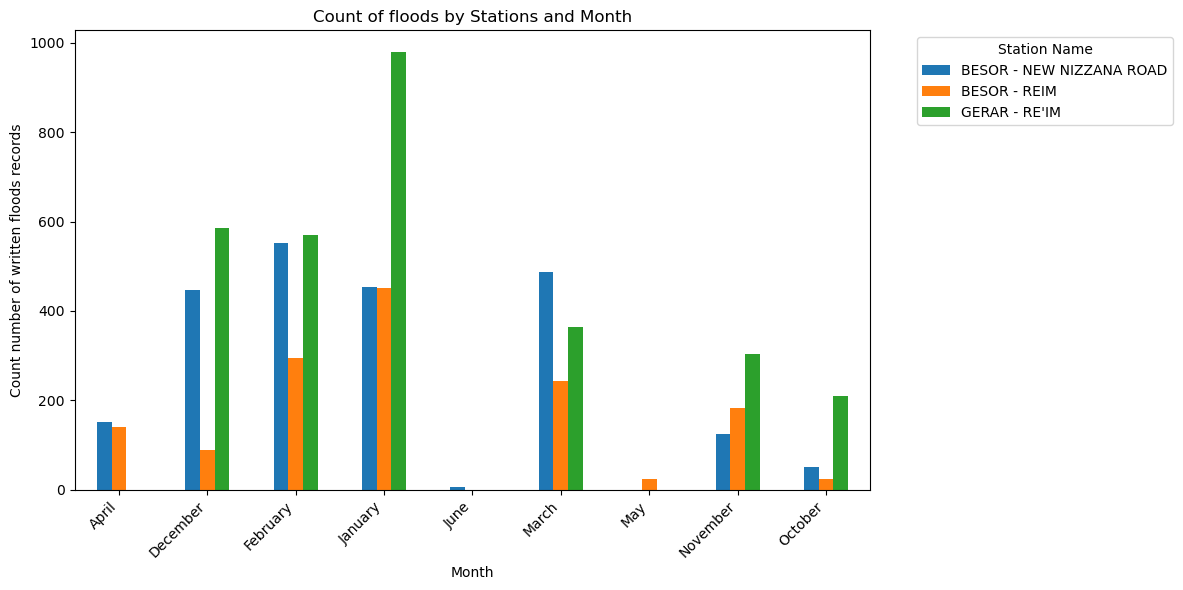

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

df_hidro['month'] = df_hidro['datetime'].dt.month
df_hidro['year'] = df_hidro['datetime'].dt.year
station_month_counts = df_hidro.groupby(by=['month', 'זיהוי תחנה', 'שם תחנה באנגלית']).size().reset_index(name='Count')

station_month_counts['month'] = station_month_counts['month'].apply(lambda x: calendar.month_name[x])
# Group by month and station name, and sum the counts
monthly_counts = station_month_counts.groupby(['month', 'שם תחנה באנגלית']).sum()['Count'].unstack(fill_value=0)

months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_counts_sorted = monthly_counts.reindex(months_order)

# Plotting
monthly_counts.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Month')
plt.ylabel('Count number of written floods records')
plt.title('Count of floods by Stations and Month')
plt.legend(title='Station Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

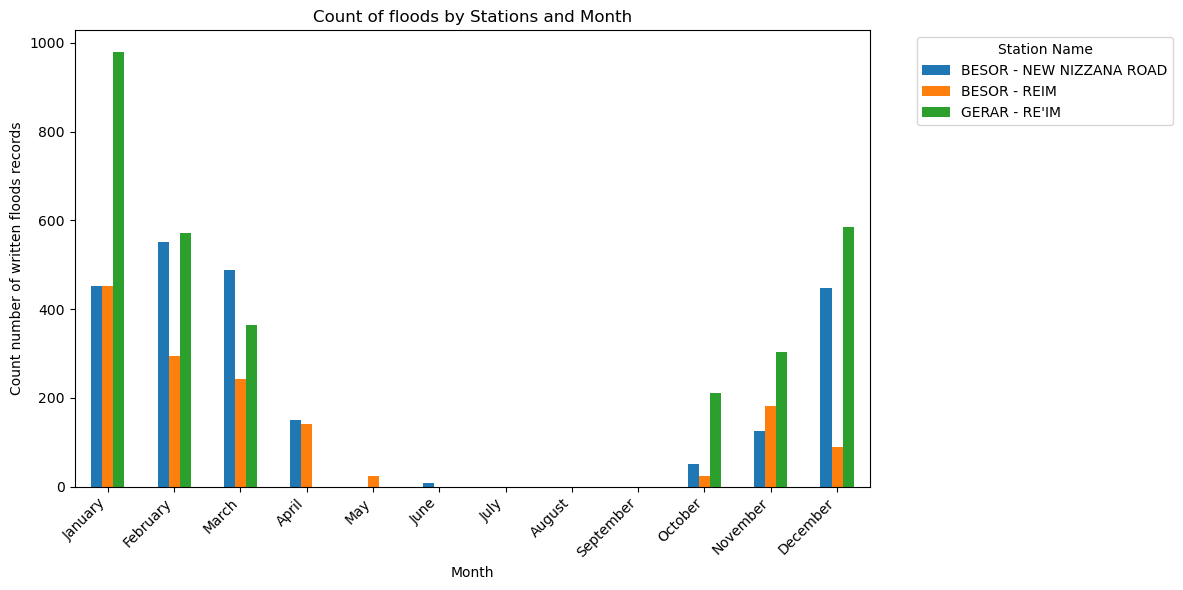

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

df_hidro['month'] = df_hidro['datetime'].dt.month
df_hidro['year'] = df_hidro['datetime'].dt.year
station_month_counts = df_hidro.groupby(by=['month', 'זיהוי תחנה', 'שם תחנה באנגלית'])["ספיקה (מ''ק/שנייה)"].mean().reset_index(name='avg flow')

station_month_counts['month'] = station_month_counts['month'].apply(lambda x: calendar.month_name[x])
# Group by month and station name, and sum the counts

months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
station_month_counts = monthly_counts.reindex(months_order)

# Plotting
station_month_counts.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Month')
plt.ylabel('Count number of written floods records')
plt.title('Count of floods by Stations and Month')
plt.legend(title='Station Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

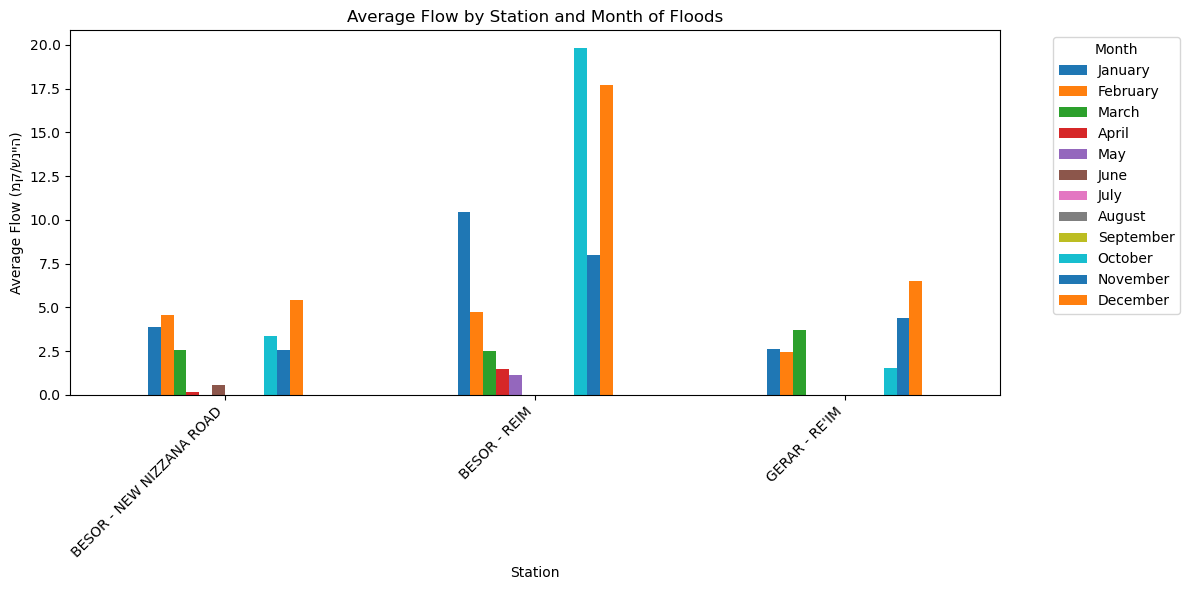

In [ ]:
# Pivot the DataFrame to have months as columns and stations as rows, with average flow as values
pivot_table = station_month_counts.pivot(index='שם תחנה באנגלית', columns='month', values='avg flow')

# Reorder columns to have months in chronological order
pivot_table = pivot_table.reindex(columns=months_order)

# Plotting
pivot_table.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Station')
plt.ylabel('Average Flow (מ''ק/שנייה)')
plt.title('Average Flow by Station and Month of Floods')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
df_hidro["ספיקה (מ''ק/שנייה)"].sort_values(ascending=False).iloc[0:50]

190     295.500
337     294.250
159     290.500
344     240.500
191     199.250
14      164.250
78      144.330
23      131.400
79      116.100
56      107.000
697     104.090
74      102.150
267      99.240
120      98.270
129      97.550
97       96.270
740      94.450
961      94.375
296      93.500
288      93.500
135      92.460
138      91.600
137      91.600
775      90.650
154      85.900
295      84.950
214      83.050
763      83.050
569      83.020
56       82.570
38       82.570
776      82.100
756      81.280
83       79.250
449      77.400
340      76.500
36       74.250
526      72.820
383      71.100
74       71.100
372      71.100
96       70.790
718      70.330
346      69.300
654      69.300
249      68.720
1005     68.720
37       68.520
216      68.430
701      66.380
Name: ספיקה (מ''ק/שנייה), dtype: float64

In [ ]:
station_month_counts = df_hidro.groupby(by=['month', 'זיהוי תחנה', 'שם תחנה באנגלית'])["ספיקה (מ''ק/שנייה)"].mean().reset_index(name='avg flow')
station_month_counts['month'] = station_month_counts['month'].apply(lambda x: calendar.month_name[x])
station_month_counts

,month,זיהוי תחנה,שם תחנה באנגלית,avg flow
0,January,23105,BESOR - NEW NIZZANA ROAD,3.899634
1,January,23150,BESOR - REIM,10.448763
2,January,23160,GERAR - RE'IM,2.595981
3,February,23105,BESOR - NEW NIZZANA ROAD,4.550481
4,February,23150,BESOR - REIM,4.719925
5,February,23160,GERAR - RE'IM,2.457089
6,March,23105,BESOR - NEW NIZZANA ROAD,2.580696
7,March,23150,BESOR - REIM,2.511531
8,March,23160,GERAR - RE'IM,3.730658
9,April,23105,BESOR - NEW NIZZANA ROAD,0.141669


In [ ]:
station_month_counts

שם תחנה באנגלית,BESOR - NEW NIZZANA ROAD,BESOR - REIM,GERAR - RE'IM
month,,,
January,453.0,452.0,979.0
February,551.0,295.0,571.0
March,487.0,243.0,365.0
April,151.0,141.0,0.0
May,0.0,24.0,0.0
June,7.0,0.0,0.0
July,NaN,NaN,NaN
August,NaN,NaN,NaN
September,NaN,NaN,NaN


In [ ]:
station_month_counts

,month,זיהוי תחנה,שם תחנה,Count
12,June,23105,בשור-כביש נצנה החדש,7
14,October,23150,בשור - רעים,23
11,May,23150,בשור - רעים,24
13,October,23105,בשור-כביש נצנה החדש,51
20,December,23150,בשור - רעים,89
16,November,23105,בשור-כביש נצנה החדש,125
10,April,23150,בשור - רעים,141
9,April,23105,בשור-כביש נצנה החדש,151
17,November,23150,בשור - רעים,182
15,October,23160,גרר - רעים,210


# The next code creates the intervals of the floods

In [ ]:
import pandas as pd
from datetime import timedelta

'''
The following code attempts to find the intervals of the floods.
It does so by finding the start point of the flood, which is found if there
are now row within X hours before the time of writing the row (datetime)
The ending point it the same, if there are not row written after the current row.
'''

# Function to check if there are rows within a span of x hours before the data point
def check_start_within_x_hours(date_time, df, x):
    start_date = date_time - timedelta(hours=x)
    end_date = date_time
    # If there are any rows between start and end date - then false, otherwise start - true
    return not ((df['datetime'] > start_date) & (df['datetime'] < end_date)).any()

# Function to check if there are rows within a span of x hours before the data point
def check_end_within_x_hours(date_time, df, x):
    start_date = date_time
    end_date = date_time + timedelta(hours=x)
    # If there are any rows between start and end date - then false, otherwise end - true
    return not ((df['datetime'] > start_date) & (df['datetime'] < end_date)).any()

def create_intervals(df, station_code, max_diff_between_two_docs = 12):
    # Initialize variables to store start and finish dates, and number of messuements
    start_date = None
    finish_date = None
    num_messurments = 0
    intervals = []
    df = df[df['זיהוי תחנה'] == station_code]
    df = df.sort_values(by = 'datetime')

    # Iterate over the DataFrame. I will try 3 hours for example
    for index, row in df.iterrows():
        date = row['datetime']
        num_messurments  = num_messurments + 1
        if start_date is None and check_start_within_x_hours(date, df, max_diff_between_two_docs):
            start_date = date
        if start_date is not None and finish_date is None and check_end_within_x_hours(date, df, max_diff_between_two_docs):
            finish_date = date
            intervals.append({'Start Date': start_date, 'Finish Date': finish_date, 'Num Messurments': num_messurments})
            start_date = None
            finish_date = None
            num_messurments = 0 # Reset

    flood_intervals_df = pd.DataFrame(intervals)
    # Calculate the timedelta between start and finish dates
    flood_intervals_df['TimeDiffHours'] = (flood_intervals_df['Finish Date'] - flood_intervals_df['Start Date']).dt.total_seconds() / 3600

    return flood_intervals_df

In [ ]:
max_diff_between_two_docs = 3 # An example of 3 hours between 2 docs

hidro_stations = df_hidro['זיהוי תחנה'].drop_duplicates()
flood_intervals_df = pd.DataFrame()
for hidro_station in hidro_stations:
     hidro_stations_flood_interval = create_intervals(df_hidro, hidro_station, max_diff_between_two_docs)
     hidro_stations_flood_interval['hidro_station'] = hidro_station
     #rain_stations_features_city['rain_date	'] = rain_stations_features_city.reset_index(drop=True).index
     flood_intervals_df = pd.concat([flood_intervals_df, hidro_stations_flood_interval], ignore_index=True)

flood_intervals_df

,Start Date,Finish Date,Num Messurments,TimeDiffHours,hidro_station
0,2000-10-26 17:06:00,2000-10-26 19:53:00,7,2.783333,23160
1,2000-12-19 15:54:00,2000-12-19 23:22:00,8,7.466667,23160
2,2000-12-20 14:10:00,2000-12-21 05:03:00,10,14.883333,23160
3,2000-12-24 20:11:00,2000-12-26 14:04:00,59,41.883333,23160
4,2001-01-03 08:44:00,2001-01-03 15:06:00,10,6.366667,23160
...,...,...,...,...,...
999,2023-03-14 16:00:00,2023-03-15 04:20:00,93,12.333333,23105
1000,2023-03-21 02:10:00,2023-03-21 15:10:00,141,13.000000,23105
1001,2023-04-10 15:40:00,2023-04-10 20:10:00,56,4.500000,23105
1002,2023-04-12 04:17:11,2023-04-12 08:25:00,51,4.130278,23105


In [ ]:
# Check
max(flood_intervals_df['TimeDiffHours'])

93.69805555555556

In [ ]:
# Check
start_date = pd.to_datetime('2023-03-14')
end_date = pd.to_datetime('2023-03-16')
df_hidro[(df_hidro['datetime'] >= start_date) & (df_hidro['datetime'] <= end_date) & (df_hidro['זיהוי תחנה'] == 23105)].sort_values(by = 'datetime').iloc[0:50]

,_id,זיהוי תחנה,שם תחנה,שם תחנה באנגלית,זמן מדידת ספיקה,רום המים (מ'),ספיקה (מ''ק/שנייה),סוג נתון,סוג זרימה,סוג רשומה,rank,datetime,date,month,year
948,320782,23105,בשור-כביש נצנה החדש,BESOR - NEW NIZZANA ROAD,14/03/2023 08:30:00,5.73,0.000,מדודים,גאות,נקודה פנימית,0.057309,2023-03-14 08:30:00,2023-03-14,3,2023
321,320783,23105,בשור-כביש נצנה החדש,BESOR - NEW NIZZANA ROAD,14/03/2023 08:35:00,5.92,0.137,מדודים,גאות,נקודה פנימית,0.057309,2023-03-14 08:35:00,2023-03-14,3,2023
1215,320784,23105,בשור-כביש נצנה החדש,BESOR - NEW NIZZANA ROAD,14/03/2023 08:40:00,5.93,0.150,מדודים,גאות,נקודה פנימית,0.057309,2023-03-14 08:40:00,2023-03-14,3,2023
607,320785,23105,בשור-כביש נצנה החדש,BESOR - NEW NIZZANA ROAD,14/03/2023 08:45:00,5.93,0.150,מדודים,גאות,נקודה פנימית,0.057309,2023-03-14 08:45:00,2023-03-14,3,2023
932,320786,23105,בשור-כביש נצנה החדש,BESOR - NEW NIZZANA ROAD,14/03/2023 08:50:00,5.92,0.137,מדודים,גאות,נקודה פנימית,0.057309,2023-03-14 08:50:00,2023-03-14,3,2023
964,320787,23105,בשור-כביש נצנה החדש,BESOR - NEW NIZZANA ROAD,14/03/2023 08:55:00,5.91,0.124,מדודים,גאות,נקודה פנימית,0.057309,2023-03-14 08:55:00,2023-03-14,3,2023
913,320788,23105,בשור-כביש נצנה החדש,BESOR - NEW NIZZANA ROAD,14/03/2023 09:00:00,5.91,0.124,מדודים,גאות,נקודה פנימית,0.057309,2023-03-14 09:00:00,2023-03-14,3,2023
928,320789,23105,בשור-כביש נצנה החדש,BESOR - NEW NIZZANA ROAD,14/03/2023 09:05:00,5.9,0.111,מדודים,גאות,נקודה פנימית,0.057309,2023-03-14 09:05:00,2023-03-14,3,2023
912,320790,23105,בשור-כביש נצנה החדש,BESOR - NEW NIZZANA ROAD,14/03/2023 09:10:00,5.91,0.124,מדודים,גאות,נקודה פנימית,0.057309,2023-03-14 09:10:00,2023-03-14,3,2023
965,320791,23105,בשור-כביש נצנה החדש,BESOR - NEW NIZZANA ROAD,14/03/2023 09:15:00,5.91,0.124,מדודים,גאות,נקודה פנימית,0.057309,2023-03-14 09:15:00,2023-03-14,3,2023


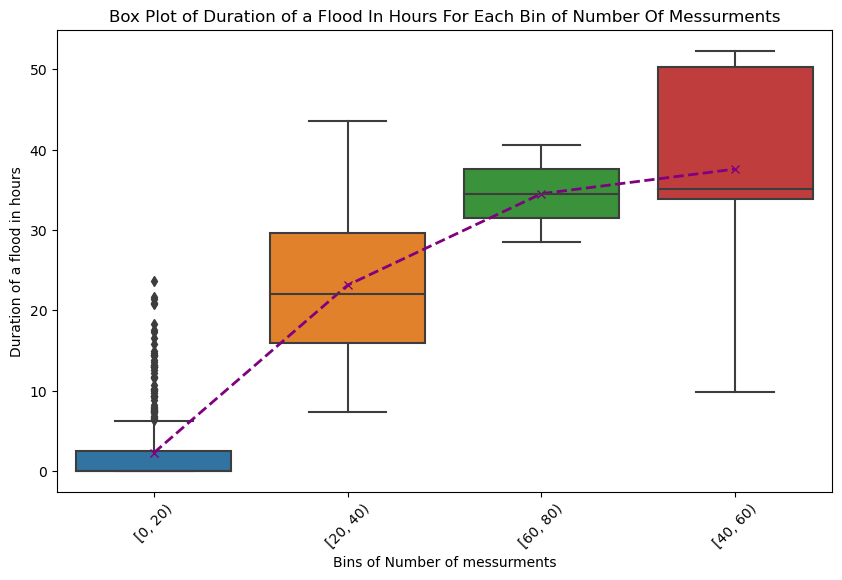

In [ ]:
# Plot an example

# Define bins for x values
bins = range(0, 100, 20)  # Creates bins from 0 to 100 with a step of 20

# Assign each value in x to its corresponding bin
flood_intervals_df['bin'] = pd.cut(flood_intervals_df['Num Messurments'], bins, right=False) # Not included The right edge

# To sort by average
bin_means = flood_intervals_df.groupby('bin')['TimeDiffHours'].mean().sort_values().index

# Calculate the average TimeDiffHours for each bin
bin_avg = flood_intervals_df.groupby('bin')['TimeDiffHours'].mean().reset_index()
bin_avg = bin_avg.sort_values(by = 'TimeDiffHours', ascending = True).reset_index()

# Create box plot using Seaborn
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.boxplot(x='bin', y='TimeDiffHours', order=bin_means, data=flood_intervals_df)

# Plot a linear line connecting the averages
plt.plot(bin_avg.index, bin_avg['TimeDiffHours'], marker='x', color='purple', linestyle='--', linewidth=2)

# Set labels and title
plt.xlabel('Bins of Number of messurments')
plt.ylabel('Duration of a flood in hours')
plt.title('Box Plot of Duration of a Flood In Hours For Each Bin of Number Of Messurments')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()

In [ ]:
df_hidro[['שם תחנה באנגלית', 'זיהוי תחנה']].drop_duplicates()

,שם תחנה באנגלית,זיהוי תחנה
755,GERAR - RE'IM,23160
121,BESOR - REIM,23150
132,BESOR - NEW NIZZANA ROAD,23105


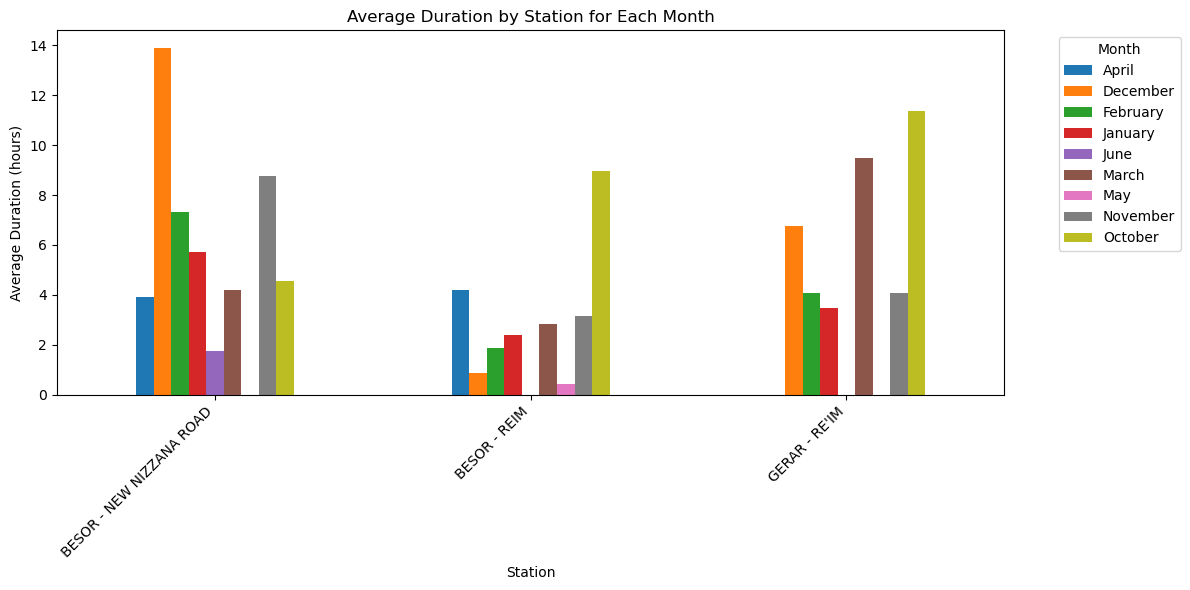

In [ ]:
def hidro_station_name(station_code):
    if station_code == 23160:
        return "GERAR - RE'IM"
    if station_code == 23150:
        return "BESOR - REIM"
    return "BESOR - NEW NIZZANA ROAD"
# Extract month from 'Start Date'
flood_intervals_df['Month'] = flood_intervals_df['Start Date'].dt.month_name()

# Calculate duration
flood_intervals_df['Duration'] = (flood_intervals_df['Finish Date'] - flood_intervals_df['Start Date']).dt.total_seconds() / 3600  # Convert to hours

flood_intervals_df['station_name'] = flood_intervals_df['hidro_station'].apply(hidro_station_name)

# Group by 'station_name' and 'Month', calculate average duration
avg_duration_by_month = flood_intervals_df.groupby(['Month', 'station_name'])['Duration'].mean().unstack()

# Transpose the DataFrame
avg_duration_by_month = avg_duration_by_month.T

# Plotting
avg_duration_by_month.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Station')
plt.ylabel('Average Duration (hours)')
plt.title('Average Duration by Station for Each Month')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# A lookup based on the data giveb from the NEGEV institute.
# The lookup has an approximation on how to long does it take
# the rain from the rain station to get into each of the hidro stations.
# Min an max are used to try and take into account if there the assumptions
# are not totally accurate (winds  speeds and directions)

rain_to_station_df = pd.DataFrame({
    'rain_station': ['Besor Farm', 'Dorot', 'Sede Boqer',
                     'Sede Boqer', 'Beer sheva',
                     'Beer sheva', 'Lahav'],
    'hidro_station': [23150, 23160, 23105, 23150,
                        23150, 23160, 23160],
    #'min_time': [5, 9, 5, 22, 14, 17, 13],
    #'max_time': [7, 11, 7, 26, 16, 19, 15]
    'interval': [6, 10, 6, 24, 15, 18, 12],
    'distance': [25, 40, 25, 95, 60, 70, 55]
})
rain_to_station_df

,rain_station,hidro_station,interval,distance
0,Besor Farm,23150,6,25
1,Dorot,23160,10,40
2,Sede Boqer,23105,6,25
3,Sede Boqer,23150,24,95
4,Beer sheva,23150,15,60
5,Beer sheva,23160,18,70
6,Lahav,23160,12,55


# Try and create the features. For all the data, create on huge dataframe

In [ ]:
import os
import pandas as pd

# Define the directory path
directory = '/content/drive/MyDrive/BigDataProject/meteorological_stations_Data'

# Define the list of city names. ADD all the citys when run the final!!
city_names = ['Beer sheva', 'Dorot', 'Besor Farm', 'Lahav', 'Sede Boqer']  # Add more city names as needed

# Initialize an empty dictionary to store DataFrames for each city
city_dataframes = {}

# Iterate over each city name
for city_name in city_names:
    # Initialize an empty list to store DataFrames for the current city
    city_dfs = []

    # List all files in the directory
    files = os.listdir(directory)

    # Iterate over the files
    for file in files:
        # Check if the file name contains the city name
        if city_name.lower() in file.lower():
            # Load the DataFrame from the file
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path)
            df['תחנה'] = city_name
            # Append the DataFrame to the list
            city_dfs.append(df)

    # Store the list of DataFrames for the current city in the dictionary
    city_dataframes[city_name] = city_dfs

# Now, city_dataframes dictionary contains lists of DataFrames for each city
# You can access the list of DataFrames for a specific city like this:
# dfs = city_dataframes['city_name']



In [ ]:
big_dataframe = pd.concat([pd.concat(dfs) for dfs in city_dataframes.values()])
big_dataframe

,תחנה,תאריך ושעה (שעון קיץ),לחות יחסית (%),טמפרטורה (C°),טמפרטורת מקסימום (C°),טמפרטורת מינימום (C°),טמפרטורה ליד הקרקע (C°),טמפרטורה לחה (C°),כיוון הרוח (מעלות),מהירות רוח דקתית מקסימלית (מטר לשניה),מהירות רוח 10 דקתית מקסימלית (מטר לשניה),סטיית התקן של כיוון הרוח (מעלות),"כמות גשם (מ""מ)"
0,Beer sheva,01/09/2000 00:00,-,23.3,23.3,23.2,22.2,21.0,309,-,-,15.3,0
1,Beer sheva,01/09/2000 00:10,-,23.2,23.2,23.1,22.1,21.0,307,-,-,16.2,0
2,Beer sheva,01/09/2000 00:20,-,23.1,23.2,23.0,21.9,20.9,309,-,-,16.1,0
3,Beer sheva,01/09/2000 00:30,-,22.9,23.0,22.9,21.8,20.8,304,-,-,12.8,0
4,Beer sheva,01/09/2000 00:40,-,22.8,22.9,22.8,21.5,20.7,298,-,-,14.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39267,Sede Boqer,31/05/2023 23:20,40,19.6,19.7,19.5,NaN,NaN,358,1.5,1.3,4.6,0.0
39268,Sede Boqer,31/05/2023 23:30,39,19.5,19.7,19.3,NaN,NaN,1,1.1,1,6.3,0.0
39269,Sede Boqer,31/05/2023 23:40,40,19.1,19.3,18.9,NaN,NaN,29,1.3,1.1,8.7,0.0
39270,Sede Boqer,31/05/2023 23:50,39,18.9,19,18.9,NaN,NaN,39,1.6,1.4,4.5,0.0


In [ ]:
big_dataframe.rename(columns=
                               {
                                   'תחנה': 'rain_station',
                                  'טמפרטורה ליד הקרקע (C°)': 'TG',
                                   'לחות יחסית (%)': 'RH',
                                   'תאריך ושעה (שעון קיץ)': 'rain_date',
                                   'כיוון הרוח (מעלות)': 'WD',
                                   'מהירות רוח דקתית מקסימלית (מטר לשניה)': 'Ws1mm',
                                   'מהירות רוח 10 דקתית מקסימלית (מטר לשניה)': 'Ws10mm',
                                   'כמות גשם (מ"מ)': 'rain_amount',
                                   'טמפרטורה (C°)': 'TD'
                               }, inplace = True)

big_dataframe['rain_date'] = pd.to_datetime(big_dataframe['rain_date'], format="%d/%m/%Y %H:%M")
big_dataframe.set_index('rain_date', inplace=True)

In [ ]:
# Because of many misssing values, and the fact that not all the stations
# have all the features, we will take only the 3 main once, like
# in the previuse work

big_dataframe = big_dataframe[['rain_station', 'TD', 'rain_amount', 'RH']]
print(big_dataframe.shape)
# Convert object columns to numeric
big_dataframe[['TD', 'rain_amount', 'RH']] = big_dataframe[['TD', 'rain_amount', 'RH']].apply(pd.to_numeric, errors='coerce')


# Remove rows where there are '-' instead of a number
big_dataframe = big_dataframe.dropna()
# Now, big_dataframe contains numeric data with rows where there are '-' removed

print(big_dataframe.dtypes)
print(big_dataframe.shape)
big_dataframe.head()


(3971453, 4)
rain_station     object
TD              float64
rain_amount     float64
RH              float64
dtype: object
(3725716, 4)


,rain_station,TD,rain_amount,RH
rain_date,,,,
2001-09-01 00:00:00,Beer sheva,23.8,0.0,78.0
2001-09-01 00:10:00,Beer sheva,23.7,0.0,78.0
2001-09-01 00:20:00,Beer sheva,23.6,0.0,79.0
2001-09-01 00:30:00,Beer sheva,23.5,0.0,79.0
2001-09-01 00:40:00,Beer sheva,23.4,0.0,79.0


In [ ]:
def Features_Extraction(df, stationName):
  '''
  This function return the dataframe with the extraction features over the data
  Note that every row is 10 minutes apart, which makes life easier.
  We will do more time windows for the rain_amount, per the request of
  the Negev institution
  '''
  df_copy = df[df['rain_station'] == stationName]
  print(df_copy.shape)

  # Create an empty DataFrame
  df_features = pd.DataFrame()

  # Sort the DataFrame by date if it's not already sorted
  # For rain amount, as requested by the Negev Institute, we will calculate more time windows
  # for the rain amoumt: 30, 60, 120, 180, 300, 600, 1200 minutes.

  # Define time-based window sizes
  time_windows = [pd.Timedelta(minutes=30), pd.Timedelta(hours=1), pd.Timedelta(hours=2),
                  pd.Timedelta(hours=3), pd.Timedelta(hours=5), pd.Timedelta(hours=10),
                  pd.Timedelta(hours=20)]

  for window_size in time_windows:
      column_prefix = f'rain_amount_{int(window_size.seconds / 60)}_'  # Prefix for column names
      df_features[column_prefix + 'mean'] = df_copy['rain_amount'].rolling(window=window_size).mean()
      df_features[column_prefix + 'median'] = df_copy['rain_amount'].rolling(window=window_size).median()
      df_features[column_prefix + 'std'] = df_copy['rain_amount'].rolling(window=window_size).std()
      df_features[column_prefix + 'max'] = df_copy['rain_amount'].rolling(window=window_size).max()
      df_features[column_prefix + 'min'] = df_copy['rain_amount'].rolling(window=window_size).min()
      df_features[column_prefix + 'EMA'] = df_copy['rain_amount'].ewm(span = window_size.seconds / 60).mean()
      column_prefix = f'TD_{int(window_size.seconds / 60)}_'  # Prefix for column names
      df_features[column_prefix + 'mean'] = df_copy['TD'].rolling(window=window_size).mean()
      df_features[column_prefix + 'median'] = df_copy['TD'].rolling(window=window_size).median()
      df_features[column_prefix + 'std'] = df_copy['TD'].rolling(window=window_size).std()
      df_features[column_prefix + 'max'] = df_copy['TD'].rolling(window=window_size).max()
      df_features[column_prefix + 'min'] = df_copy['TD'].rolling(window=window_size).min()
      df_features[column_prefix + 'EMA'] = df_copy['TD'].ewm(span = window_size.seconds / 60).mean()
      column_prefix = f'RH_{int(window_size.seconds / 60)}_'  # Prefix for column names
      df_features[column_prefix + 'mean'] = df_copy['RH'].rolling(window=window_size).mean()
      df_features[column_prefix + 'median'] = df_copy['RH'].rolling(window=window_size).median()
      df_features[column_prefix + 'std'] = df_copy['RH'].rolling(window=window_size).std()
      df_features[column_prefix + 'max'] = df_copy['RH'].rolling(window=window_size).max()
      df_features[column_prefix + 'min'] = df_copy['RH'].rolling(window=window_size).min()
      df_features[column_prefix + 'EMA'] = df_copy['RH'].ewm(span = window_size.seconds / 60).mean()
  # Remove rows earlier than the maximum window size
  window_sizes = [int(window_size.total_seconds() / 60) for window_size in time_windows]
  max_window_size = max(window_sizes)
  df_features = df_features.iloc[max_window_size - 1:]
  # No need if there was no rain in the last 20 hours
  df_features = df_features[df_features['rain_amount_1200_max'] > 0]
  df_features['rain_station'] = stationName
  df_features['rain_date'] = df_features.index
  #df_features.reset_index(inplace = True)
  return df_features

In [ ]:
# check
time_windows = [pd.Timedelta(minutes=30), pd.Timedelta(hours=1), pd.Timedelta(hours=2),
                  pd.Timedelta(hours=3), pd.Timedelta(hours=5), pd.Timedelta(hours=10),
                  pd.Timedelta(hours=20)]

for window_size in time_windows:
    print(window_size)

0 days 00:30:00
0 days 01:00:00
0 days 02:00:00
0 days 03:00:00
0 days 05:00:00
0 days 10:00:00
0 days 20:00:00


In [ ]:
# We take for each city of course, to not mix all the data
rain_stations_features = pd.DataFrame()
city_names = ['Beer sheva', 'Dorot', 'Besor Farm', 'Lahav', 'Sede Boqer']  # Add more city names as needed

for city_name in city_names:
     rain_stations_features_city = Features_Extraction(big_dataframe, city_name)
     #rain_stations_features_city['rain_date	'] = rain_stations_features_city.reset_index(drop=True).index
     rain_stations_features = pd.concat([rain_stations_features, rain_stations_features_city], ignore_index=True)

rain_stations_features

(827804, 4)


C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'min'] = df_copy['TD'].rolling(window=window_size).min()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'EMA'] = df_copy['TD'].ewm(span = window_size.seconds / 60).mean()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usu

C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'median'] = df_copy['RH'].rolling(window=window_size).median()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'std'] = df_copy['RH'].rolling(window=window_size).std()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually

(793803, 4)


C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'min'] = df_copy['TD'].rolling(window=window_size).min()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'EMA'] = df_copy['TD'].ewm(span = window_size.seconds / 60).mean()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usu

C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'median'] = df_copy['RH'].rolling(window=window_size).median()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'std'] = df_copy['RH'].rolling(window=window_size).std()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually

(824584, 4)


C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'min'] = df_copy['TD'].rolling(window=window_size).min()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'EMA'] = df_copy['TD'].ewm(span = window_size.seconds / 60).mean()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usu

C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'median'] = df_copy['RH'].rolling(window=window_size).median()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'std'] = df_copy['RH'].rolling(window=window_size).std()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually

(500995, 4)


C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'min'] = df_copy['TD'].rolling(window=window_size).min()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'EMA'] = df_copy['TD'].ewm(span = window_size.seconds / 60).mean()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usu

C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'median'] = df_copy['RH'].rolling(window=window_size).median()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'std'] = df_copy['RH'].rolling(window=window_size).std()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually

(778530, 4)


C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'min'] = df_copy['TD'].rolling(window=window_size).min()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'EMA'] = df_copy['TD'].ewm(span = window_size.seconds / 60).mean()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usu

C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'median'] = df_copy['RH'].rolling(window=window_size).median()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[column_prefix + 'std'] = df_copy['RH'].rolling(window=window_size).std()
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3050182513.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually

,rain_amount_30_mean,rain_amount_30_median,rain_amount_30_std,rain_amount_30_max,rain_amount_30_min,rain_amount_30_EMA,TD_30_mean,TD_30_median,TD_30_std,TD_30_max,...,TD_1200_min,TD_1200_EMA,RH_1200_mean,RH_1200_median,RH_1200_std,RH_1200_max,RH_1200_min,RH_1200_EMA,rain_station,rain_date
0,0.033333,0.0,0.057735,0.1,0.0,0.006452,15.566667,15.5,0.208167,15.8,...,15.3,21.882564,61.683333,64.5,14.588463,83.0,39.0,66.190229,Beer sheva,2001-10-22 05:00:00
1,0.033333,0.0,0.057735,0.1,0.0,0.006035,15.800000,15.8,0.300000,16.1,...,15.3,21.872935,61.875000,65.0,14.756034,86.0,39.0,66.223218,Beer sheva,2001-10-22 05:10:00
2,0.033333,0.0,0.057735,0.1,0.0,0.005646,16.033333,16.1,0.208167,16.2,...,15.3,21.863488,62.075000,65.0,14.919483,86.0,39.0,66.256152,Beer sheva,2001-10-22 05:20:00
3,0.000000,0.0,0.000000,0.0,0.0,0.005282,16.133333,16.1,0.057735,16.2,...,15.3,21.853890,62.258333,65.0,15.040838,86.0,39.0,66.284035,Beer sheva,2001-10-22 05:30:00
4,0.000000,0.0,0.000000,0.0,0.0,0.004941,16.033333,16.1,0.208167,16.2,...,15.3,21.843808,62.458333,65.5,15.156270,86.0,39.0,66.311872,Beer sheva,2001-10-22 05:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515951,0.000000,0.0,0.000000,0.0,0.0,0.000020,18.166667,18.2,0.057735,18.2,...,17.8,23.211406,75.650000,82.5,15.955110,94.0,51.0,48.861988,Sede Boqer,2023-05-29 07:30:00
515952,0.000000,0.0,0.000000,0.0,0.0,0.000019,18.200000,18.2,0.100000,18.3,...,17.8,23.203227,75.758333,85.0,16.001573,94.0,51.0,48.928829,Sede Boqer,2023-05-29 07:40:00
515953,0.000000,0.0,0.000000,0.0,0.0,0.000018,18.333333,18.3,0.152753,18.5,...,17.8,23.195395,75.833333,86.0,16.033229,94.0,51.0,48.992228,Sede Boqer,2023-05-29 07:50:00
515954,0.000000,0.0,0.000000,0.0,0.0,0.000016,18.466667,18.5,0.152753,18.6,...,17.8,23.187742,75.900000,86.0,16.058925,94.0,51.0,49.053856,Sede Boqer,2023-05-29 08:00:00


In [ ]:
print(rain_stations_features.shape)
rain_stations_features.head(10)

(515956, 128)


,rain_amount_30_mean,rain_amount_30_median,rain_amount_30_std,rain_amount_30_max,rain_amount_30_min,rain_amount_30_EMA,TD_30_mean,TD_30_median,TD_30_std,TD_30_max,...,TD_1200_min,TD_1200_EMA,RH_1200_mean,RH_1200_median,RH_1200_std,RH_1200_max,RH_1200_min,RH_1200_EMA,rain_station,rain_date
0,0.033333,0.0,0.057735,0.1,0.0,0.006452,15.566667,15.5,0.208167,15.8,...,15.3,21.882564,61.683333,64.5,14.588463,83.0,39.0,66.190229,Beer sheva,2001-10-22 05:00:00
1,0.033333,0.0,0.057735,0.1,0.0,0.006035,15.800000,15.8,0.300000,16.1,...,15.3,21.872935,61.875000,65.0,14.756034,86.0,39.0,66.223218,Beer sheva,2001-10-22 05:10:00
2,0.033333,0.0,0.057735,0.1,0.0,0.005646,16.033333,16.1,0.208167,16.2,...,15.3,21.863488,62.075000,65.0,14.919483,86.0,39.0,66.256152,Beer sheva,2001-10-22 05:20:00
3,0.000000,0.0,0.000000,0.0,0.0,0.005282,16.133333,16.1,0.057735,16.2,...,15.3,21.853890,62.258333,65.0,15.040838,86.0,39.0,66.284035,Beer sheva,2001-10-22 05:30:00
4,0.000000,0.0,0.000000,0.0,0.0,0.004941,16.033333,16.1,0.208167,16.2,...,15.3,21.843808,62.458333,65.5,15.156270,86.0,39.0,66.311872,Beer sheva,2001-10-22 05:40:00
5,0.000000,0.0,0.000000,0.0,0.0,0.004622,15.833333,15.8,0.251661,16.1,...,15.3,21.833411,62.675000,66.0,15.263051,86.0,39.0,66.339662,Beer sheva,2001-10-22 05:50:00
6,0.000000,0.0,0.000000,0.0,0.0,0.004324,15.666667,15.6,0.115470,15.8,...,15.3,21.823030,62.908333,66.5,15.373772,86.0,39.0,66.369072,Beer sheva,2001-10-22 06:00:00
7,0.000000,0.0,0.000000,0.0,0.0,0.004045,15.600000,15.6,0.000000,15.6,...,15.3,21.812667,63.150000,67.5,15.491744,86.0,39.0,66.400098,Beer sheva,2001-10-22 06:10:00
8,0.000000,0.0,0.000000,0.0,0.0,0.003784,15.600000,15.6,0.000000,15.6,...,15.3,21.802321,63.416667,68.0,15.607897,86.0,39.0,66.432737,Beer sheva,2001-10-22 06:20:00
9,0.000000,0.0,0.000000,0.0,0.0,0.003540,15.566667,15.6,0.057735,15.6,...,15.3,21.791826,63.708333,68.0,15.700664,86.0,39.0,66.465322,Beer sheva,2001-10-22 06:30:00


# An example of attempting to create the dataset for the classification task

In [ ]:
rain_stations_features.columns

Index(['rain_amount_30_mean', 'rain_amount_30_median', 'rain_amount_30_std',
       'rain_amount_30_max', 'rain_amount_30_min', 'rain_amount_30_EMA',
       'TD_30_mean', 'TD_30_median', 'TD_30_std', 'TD_30_max',
       ...
       'TD_1200_min', 'TD_1200_EMA', 'RH_1200_mean', 'RH_1200_median',
       'RH_1200_std', 'RH_1200_max', 'RH_1200_min', 'RH_1200_EMA',
       'rain_station', 'rain_date'],
      dtype='object', length=128)

In [ ]:
import pandas as pd

# Assuming you have hidro_df, rain_stations_df, and rain_to_station_df already defined
# Reset the index of attmept DataFrame
#attmept_reset_index = attmept.reset_index()

# Extract the datetime column
#datetime_column = attmept_reset_index['rain_date']

rain_data = rain_stations_features

# Merge rain_to_station_df with hidro_df on hidro_station
rain_data = pd.merge(rain_data, rain_to_station_df, on = 'rain_station', how='inner')

# Convert min_time and max_time to timedelta
rain_data['interval'] = pd.to_timedelta(rain_data['interval'], unit='h')

In [ ]:
rain_data.dtypes

rain_amount_30_mean              float64
rain_amount_30_median            float64
rain_amount_30_std               float64
rain_amount_30_max               float64
rain_amount_30_min               float64
                              ...       
rain_station                      object
rain_date                 datetime64[ns]
hidro_station                      int64
interval                 timedelta64[ns]
distance                           int64
Length: 131, dtype: object

In [ ]:
print(rain_data.shape)
rain_data[rain_data['rain_station'] == 'Besor Farm'].head()

(700374, 131)


,rain_amount_30_mean,rain_amount_30_median,rain_amount_30_std,rain_amount_30_max,rain_amount_30_min,rain_amount_30_EMA,TD_30_mean,TD_30_median,TD_30_std,TD_30_max,...,RH_1200_median,RH_1200_std,RH_1200_max,RH_1200_min,RH_1200_EMA,rain_station,rain_date,hidro_station,interval,distance
341436,0.033333,0.0,0.057735,0.1,0.0,0.006452,10.633333,10.6,0.152753,10.8,...,85.0,15.829871,99.0,49.0,66.107056,Besor Farm,2002-02-09 02:00:00,23150,0 days 06:00:00,25
341437,0.033333,0.0,0.057735,0.1,0.0,0.006035,10.900000,10.8,0.458258,11.4,...,85.0,15.900522,99.0,49.0,66.166496,Besor Farm,2002-02-09 02:10:00,23150,0 days 06:00:00,25
341438,0.033333,0.0,0.057735,0.1,0.0,0.005646,11.300000,11.4,0.458258,11.7,...,85.0,15.960657,99.0,49.0,66.224014,Besor Farm,2002-02-09 02:20:00,23150,0 days 06:00:00,25
341439,0.000000,0.0,0.000000,0.0,0.0,0.005282,11.600000,11.7,0.173205,11.7,...,85.0,15.960657,99.0,49.0,66.268774,Besor Farm,2002-02-09 02:30:00,23150,0 days 06:00:00,25
341440,0.000000,0.0,0.000000,0.0,0.0,0.004941,11.700000,11.7,0.000000,11.7,...,85.0,15.945282,99.0,49.0,66.308027,Besor Farm,2002-02-09 02:40:00,23150,0 days 06:00:00,25


In [ ]:
def check_condition(row):
    # Find corresponding rows in df2 based on hidro_station
    #ADD THE FILTER WHEN RUNNING THE WHOLE CODE!!!!!!!!!!!!
    matching_rows = flood_intervals_df_station
    # Iterate through matching rows
    for _, match_row in matching_rows.iterrows():
        # Check if datetime is within the specified range after start_rain
        if (row['rain_date'] >= match_row['Start Date'] - row['interval']) and (row['rain_date'] <= match_row['Finish Date'] - row['interval']):
            return 1
    return 0

In [ ]:
city_names = ['Beer sheva', 'Dorot', 'Besor Farm', 'Lahav', 'Sede Boqer']  # Add more city names as needed
hidro_stations = df_hidro['זיהוי תחנה'].drop_duplicates()
final_df = pd.DataFrame()

for city_name in city_names:
    for hidro_station in hidro_stations:
        flood_intervals_df_station = flood_intervals_df[flood_intervals_df['hidro_station'] == hidro_station]
        rain_data_city_station = rain_data[(rain_data['rain_station'] == city_name) & (rain_data['hidro_station'] == hidro_station)]
             # Check if rain_data_city_station is not empty
        if not rain_data_city_station.empty:
            # Apply the function only if rain_data_city_station is not empty
            rain_data_city_station['flood'] = rain_data_city_station.apply(check_condition, axis=1)
            final_df = pd.concat([final_df, rain_data_city_station], ignore_index=True)

final_df

C:\Users\User\AppData\Local\Temp\ipykernel_7712\3234035951.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rain_data_city_station['flood'] = rain_data_city_station.apply(check_condition, axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3234035951.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rain_data_city_station['flood'] = rain_data_city_station.apply(check_condition, axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_7712\3234035951.py:12: PerformanceWarning: DataFrame is highly fragmented.  This

,rain_amount_30_mean,rain_amount_30_median,rain_amount_30_std,rain_amount_30_max,rain_amount_30_min,rain_amount_30_EMA,TD_30_mean,TD_30_median,TD_30_std,TD_30_max,...,RH_1200_std,RH_1200_max,RH_1200_min,RH_1200_EMA,rain_station,rain_date,hidro_station,interval,distance,flood
0,0.033333,0.0,0.057735,0.1,0.0,0.006452,15.566667,15.5,0.208167,15.8,...,14.588463,83.0,39.0,66.190229,Beer sheva,2001-10-22 05:00:00,23160,0 days 18:00:00,70,0
1,0.033333,0.0,0.057735,0.1,0.0,0.006035,15.800000,15.8,0.300000,16.1,...,14.756034,86.0,39.0,66.223218,Beer sheva,2001-10-22 05:10:00,23160,0 days 18:00:00,70,0
2,0.033333,0.0,0.057735,0.1,0.0,0.005646,16.033333,16.1,0.208167,16.2,...,14.919483,86.0,39.0,66.256152,Beer sheva,2001-10-22 05:20:00,23160,0 days 18:00:00,70,0
3,0.000000,0.0,0.000000,0.0,0.0,0.005282,16.133333,16.1,0.057735,16.2,...,15.040838,86.0,39.0,66.284035,Beer sheva,2001-10-22 05:30:00,23160,0 days 18:00:00,70,0
4,0.000000,0.0,0.000000,0.0,0.0,0.004941,16.033333,16.1,0.208167,16.2,...,15.156270,86.0,39.0,66.311872,Beer sheva,2001-10-22 05:40:00,23160,0 days 18:00:00,70,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700369,0.000000,0.0,0.000000,0.0,0.0,0.000020,18.166667,18.2,0.057735,18.2,...,15.955110,94.0,51.0,48.861988,Sede Boqer,2023-05-29 07:30:00,23105,0 days 06:00:00,25,0
700370,0.000000,0.0,0.000000,0.0,0.0,0.000019,18.200000,18.2,0.100000,18.3,...,16.001573,94.0,51.0,48.928829,Sede Boqer,2023-05-29 07:40:00,23105,0 days 06:00:00,25,0
700371,0.000000,0.0,0.000000,0.0,0.0,0.000018,18.333333,18.3,0.152753,18.5,...,16.033229,94.0,51.0,48.992228,Sede Boqer,2023-05-29 07:50:00,23105,0 days 06:00:00,25,0
700372,0.000000,0.0,0.000000,0.0,0.0,0.000016,18.466667,18.5,0.152753,18.6,...,16.058925,94.0,51.0,49.053856,Sede Boqer,2023-05-29 08:00:00,23105,0 days 06:00:00,25,0


In [ ]:
final_df.shape

(700374, 132)

In [ ]:
final_df[['rain_station', 'hidro_station']].drop_duplicates()

,rain_station,hidro_station
0,Beer sheva,23160
105393,Beer sheva,23150
210786,Dorot,23160
341436,Besor Farm,23150
464291,Lahav,23160
542324,Sede Boqer,23150
621349,Sede Boqer,23105


In [ ]:
#final_df.to_csv(r"C:\Users\User\Desktop\פרוייקט כריית מידע במאגרים גדולים\ClassificationData.csv", index=False)